# TensorFlow Lite Converter and Interpeter

In this notebook, we'll cover how to convert a standard TF model to TFLite format, and how to load it with the TFLite interpreter to run predictions. We'll use the Python API for the TFLite interpreter, since it is the easiest to use on Linux-based embedded systems (e.g. the Raspberry Pi), although not the most efficient.

The notebook is composed of two parts:

- Part 1 is normally executed on the development system (e.g. a PC, cloud server, etc.)

- Part 2 is normally executed on the target device (e.g. a Raspberry Pi). However, for demonstration purposes, we'll run both parts on the same machine.

## Part 1: Convert a Keras model with the TFLite Converter

##### Create and train a model

We start by creating and training a standard Keras sequential model. We'll use a simple MLP with one input and one output, trained on some linearly dependent data.

In [11]:
import tensorflow as tf
import numpy as np

x_train = [-1, 0, 1]
y_train = [-3, -1, 1]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1], name='first_dense'),
    tf.keras.layers.Dense(units=16, activation='relu', name='second_dense'),
    tf.keras.layers.Dense(units=1, name='third_dense')
])
model.summary()
opt = tf.keras.optimizers.SGD(learning_rate=0.05)
model.compile(optimizer=opt, loss='mean_squared_error')
model.fit(x=x_train, y=y_train, epochs=30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_dense (Dense)          (None, 1)                 2         
_________________________________________________________________
second_dense (Dense)         (None, 16)                32        
_________________________________________________________________
third_dense (Dense)          (None, 1)                 17        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1/1 [==============================] - 0s 235ms/step - loss: 4.3240
Epoch 2/30
1/1 [==============================] - 0s 3ms/step - loss: 3.0391
Epoch 3/30
1/1 [==============================] - 0s 4ms/step - loss: 2.1813
Epoch 4/30
1/1 [==============================] - 0s 3ms/step - loss: 1.5019
Epoch 5/30
1/1 [==============================] - 0s 4ms/step - loss: 0.9270
E

##### Save the Model

After training, the next step consists in saving the model to the standard TF2 format, called "SavedModel"

In [12]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [13]:
!ls -l my_model

total 168
drwxr-xr-x  2 jah  staff     64 Nov 15 11:11 assets
-rw-r--r--  1 jah  staff   7720 Nov 15 11:14 keras_metadata.pb
-rw-r--r--  1 jah  staff  76293 Nov 15 11:14 saved_model.pb
drwxr-xr-x  4 jah  staff    128 Nov 15 11:14 variables


##### Convert the Model

Next, we can use the TFLite converter to turn the SavedModel into a `.tflite` FlatBuffer, that can be loaded by the TFLite interpreter.

In [14]:
converter = tf.lite.TFLiteConverter.from_saved_model("my_model")
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
print(tflite_model)

b'\x1c\x00\x00\x00TFL3\x14\x00 \x00\x04\x00\x08\x00\x0c\x00\x10\x00\x14\x00\x00\x00\x18\x00\x1c\x00\x14\x00\x00\x00\x03\x00\x00\x00T\x00\x00\x00H\x00\x00\x00@\x01\x00\x00\x0c\x00\x00\x00\xe8\x00\x00\x00H\x00\x00\x00\x0c\x00\x00\x00,\x07\x00\x00(\x07\x00\x00X\x06\x00\x00\xc4\x05\x00\x00x\x05\x00\x00\x1c\x05\x00\x00\x80\x04\x00\x00\xe8\x03\x00\x00\x0c\x07\x00\x00\x08\x07\x00\x00\x04\x07\x00\x00\xe4\x00\x00\x00\x01\x00\x00\x00\x1c\x01\x00\x00\x01\x00\x00\x00<\x03\x00\x00\x01\x00\x00\x00\x10\x00\x00\x00\x0c\x00\x14\x00\x10\x00\x0c\x00\x08\x00\x04\x00\x0c\x00\x00\x00\x10\x00\x00\x00\x18\x00\x00\x00(\x00\x00\x00,\x00\x00\x00\x05\x00\x00\x00serve\x00\x00\x00\x0f\x00\x00\x00serving_default\x00\x01\x00\x00\x00\x14\x00\x00\x00\x01\x00\x00\x00(\x00\x00\x00\x08\x00\x0c\x00\x08\x00\x04\x00\x08\x00\x00\x00\t\x00\x00\x00\x04\x00\x00\x00\x0b\x00\x00\x00third_dense\x00b\xfa\xff\xff\x04\x00\x00\x00\x11\x00\x00\x00first_dense_input\x00\x00\x00\x01\x00\x00\x00\x0c\x00\x00\x00\x08\x00\x0c\x00\x04\x00\x08\x

Note that in this case we could have used also `TFLiteConverter.from_keras_model(model)` to save the Keras model directly. However, real trainings take much longer, so it's typically more convenient to separate the training and conversion scripts, and do the conversion starting from a SavedModel directory.

##### Save the TFLite Model File

The output of the `convert()` function is a serialized `bytes` Python object containing the model. These data can be written to a binary file to be transferred to the taget as follows.

In [15]:
with open('my_model.tflite', 'wb') as f:
    f.write(tflite_model)

## Part 2: Run inference with the TFLite Interpreter

Remember! This second part typically takes place on a different device w.r.t. Part 1. Here it's preferable to only load `tflite`, not the entire `tf` package.

In [16]:
import tensorflow.lite as tflite

##### Load the Model

On the target, the first step consists in loading the model produced by the conversion in Part 1.

In [17]:
interpreter = tflite.Interpreter(model_path="my_model.tflite")

##### Allocate Tensors

We can use the `allocate_tensors()` memory to allocate the memory space required for inference (buffers for inputs, outputs, intermediate activations).

In [18]:
interpreter.allocate_tensors()

##### Get Input/Output Details

Retrieve a list of data structures (one for each input/output tensor) containing information such as the required shape, the index of the corresponding buffer allocated by the interpreter, etc.

In [19]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In this case, we have a single input, with shape (1, 1) - i.e. a scalar with no batching:

In [20]:
print("Number of inputs:", len(input_details))
print("Number of outputs:", len(output_details))
print("Input name:", input_details[0]['name'])
print("Input shape:", input_details[0]['shape'])

Number of inputs: 1
Number of outputs: 1
Input name: serving_default_first_dense_input:0
Input shape: [1 1]


##### Run the model

Let's generate some random input data and feed it to the model. 

In reality, here's where you should feed data from your device's sensors. So, it is common to wrap this code into an infinite loop (here we just have 10 iterations), in which we get new data from a sensor, feed it to the interpreter, and use the inference result somehow (e.g. locally to perform an action or sending it to the cloud).

Notice that, since the model is not yet quantized, input data are of type `float32`.

In [21]:
inputs = []
outputs = []
for i in range(10):

    my_input = np.array(np.random.uniform(-1, 1, input_details[0]['shape']), dtype=np.float32)
    print("Input:", my_input)
    inputs.append(my_input[0, 0])
    
    interpreter.set_tensor(input_details[0]['index'], my_input)
    
    interpreter.invoke()
    
    my_output = interpreter.get_tensor(output_details[0]['index'])
    print("Output:", my_output)  
    outputs.append(my_output[0, 0])

Input: [[0.30458838]]
Output: [[0.04943922]]
Input: [[0.1579844]]
Output: [[-0.43423685]]
Input: [[-0.11756618]]
Output: [[-1.2043735]]
Input: [[-0.6626342]]
Output: [[-2.3214538]]
Input: [[-0.34693894]]
Output: [[-1.6744576]]
Input: [[0.86319876]]
Output: [[0.81851685]]
Input: [[-0.10143956]]
Output: [[-1.1713231]]
Input: [[0.12907879]]
Output: [[-0.5378451]]
Input: [[-0.61739755]]
Output: [[-2.2287443]]
Input: [[0.9979544]]
Output: [[0.9903214]]


##### Check the Results

Let us check the results to see that the interpreter is indeed producing the expected output. Of course, in reality this should be done again on the host machine after transferring data from the target.

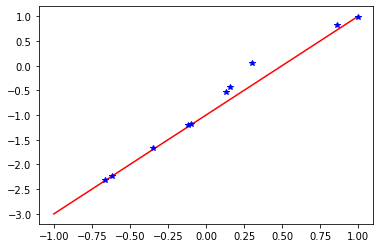

In [22]:
import matplotlib.pyplot as plt

plt.plot(x_train, y_train, 'r-')
plt.plot(inputs, outputs, 'b*')